# Comparing the EDM score with the Score of GMM and delta (MNIST)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import join
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image

In [3]:
# set pandas display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionMemorization")
from train_edm import edm_sampler, EDM, create_model
from core.edm_utils import get_default_config, create_edm

### Load Dataset

In [5]:
# load MNISR data
train_dataset = datasets.MNIST(root='~/Datasets', download=True, transform=\
    transforms.Compose([transforms.Resize((32, 32)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5), (0.5))]))

In [6]:
Xtsr = torch.stack([x for x, y in train_dataset])
ytsr = torch.tensor(train_dataset.targets)
Xtsr = Xtsr.float()
Xmat = Xtsr.view(Xtsr.shape[0], -1)
imgshape = tuple(Xtsr.shape[1:])
print(imgshape)
Xmean = Xmat.mean(dim=0)
Xcov = torch.cov(Xmat.T, )
eigvals, eigvecs = torch.linalg.eigh(Xcov.cuda(), )
torch.sum(eigvals).sqrt()

/tmp/ipykernel_323022/1548768013.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytsr = torch.tensor(train_dataset.targets)


(1, 32, 32)


tensor(15.2075, device='cuda:0')

### Mass compute

In [9]:
from core.analytical_score_lib import mean_isotropic_score, Gaussian_score, delta_GMM_score
from core.analytical_score_lib import explained_var_vec
from core.analytical_score_lib import sample_Xt_batch, sample_Xt_batch
from core.gaussian_mixture_lib import gaussian_mixture_score_batch_sigma_torch, \
    gaussian_mixture_lowrank_score_batch_sigma_torch, compute_cluster

In [8]:
device = "cuda"
edm_Xtsr = Xtsr
edm_Xmat = edm_Xtsr.view(edm_Xtsr.shape[0], -1).to(device)
edm_Xmean = edm_Xmat.mean(dim=0)
edm_Xcov = torch.cov(edm_Xmat.T, )
edm_imgshape = tuple(edm_Xtsr.shape[1:])
edm_std_mean = (torch.trace(Xcov) / Xcov.shape[0]).sqrt()

### Compute Clustering

In [10]:
kmeans_batch = 2048
kmeans_random_seed = 42
kmeans_verbose = 0
lambda_EPS = 1E-5
Us_col = {}
mus_col = {}
Lambdas_col = {}
weights_col = {}
for n_clusters in reversed([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]):
    kmeans, eigval_mat, eigvec_mat, freq_vec, center_mat = compute_cluster(edm_Xmat.cpu(), 
                            n_clusters=n_clusters,
                            kmeans_batch=kmeans_batch, 
                            kmeans_random_seed=kmeans_random_seed,
                            kmeans_verbose=kmeans_verbose,
                            lambda_EPS=lambda_EPS)
    Us_col[n_clusters] = eigvec_mat #.to(device)
    mus_col[n_clusters] = center_mat #.to(device)
    Lambdas_col[n_clusters] = eigval_mat #.to(device)
    weights = freq_vec / freq_vec.sum()
    weights_col[n_clusters] = weights #.to(device)
    print(f"n_clusters={n_clusters}, computed.")

/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  4881873.240153408


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.27it/s]


cov PCA completed for each cluster.
n_clusters=1000, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  5427480.861744916


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 38.77it/s]


cov PCA completed for each cluster.
n_clusters=500, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  6237226.22416184


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 34.58it/s]


cov PCA completed for each cluster.
n_clusters=200, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  6903994.189759604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.35it/s]


cov PCA completed for each cluster.
n_clusters=100, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  7660296.310794035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.68it/s]


cov PCA completed for each cluster.
n_clusters=50, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  8984957.10208095


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.32it/s]


cov PCA completed for each cluster.
n_clusters=20, computed.


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Kmeans fitting completing, loss  9974538.258343827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.75it/s]
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


cov PCA completed for each cluster.
n_clusters=10, computed.
Kmeans fitting completing, loss  11345889.095724596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.27it/s]
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


cov PCA completed for each cluster.
n_clusters=5, computed.
Kmeans fitting completing, loss  12905014.125940809


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.83it/s]
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


cov PCA completed for each cluster.
n_clusters=2, computed.
Kmeans fitting completing, loss  13876212.89244068


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

cov PCA completed for each cluster.
n_clusters=1, computed.


### Find Checkpoints

In [10]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist*

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342:
checkpoints  samples  std.log

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1406:
checkpoints  samples  std.log

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240130-2207:
checkpoints  samples  std.log


In [12]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1406/checkpoints/

ema_100000.pth	ema_200000.pth	ema_275000.pth	ema_375000.pth	ema_475000.pth
ema_125000.pth	ema_225000.pth	ema_300000.pth	ema_400000.pth	ema_499999.pth
ema_150000.pth	ema_250000.pth	ema_325000.pth	ema_425000.pth	ema_50000.pth
ema_175000.pth	ema_25000.pth	ema_350000.pth	ema_450000.pth	ema_75000.pth


In [13]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342/checkpoints/

ema_100000.pth	ema_300000.pth	ema_50000.pth	ema_725000.pth	ema_925000.pth
ema_125000.pth	ema_325000.pth	ema_525000.pth	ema_750000.pth	ema_950000.pth
ema_150000.pth	ema_350000.pth	ema_550000.pth	ema_75000.pth	ema_975000.pth
ema_175000.pth	ema_375000.pth	ema_575000.pth	ema_775000.pth	ema_999999.pth
ema_200000.pth	ema_400000.pth	ema_600000.pth	ema_800000.pth	eval.log
ema_225000.pth	ema_425000.pth	ema_625000.pth	ema_825000.pth
ema_250000.pth	ema_450000.pth	ema_650000.pth	ema_850000.pth
ema_25000.pth	ema_475000.pth	ema_675000.pth	ema_875000.pth
ema_275000.pth	ema_500000.pth	ema_700000.pth	ema_900000.pth


In [9]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240130-2207/checkpoints/

ema_10000.pth  ema_14500.pth  ema_19000.pth  ema_23500.pth  ema_500.pth
ema_1000.pth   ema_15000.pth  ema_19500.pth  ema_24000.pth  ema_5500.pth
ema_10500.pth  ema_1500.pth   ema_20000.pth  ema_24500.pth  ema_6000.pth
ema_11000.pth  ema_15500.pth  ema_2000.pth   ema_24999.pth  ema_6500.pth
ema_11500.pth  ema_16000.pth  ema_20500.pth  ema_2500.pth   ema_7000.pth
ema_12000.pth  ema_16500.pth  ema_21000.pth  ema_3000.pth   ema_7500.pth
ema_12500.pth  ema_17000.pth  ema_21500.pth  ema_3500.pth   ema_8000.pth
ema_13000.pth  ema_17500.pth  ema_22000.pth  ema_4000.pth   ema_8500.pth
ema_13500.pth  ema_18000.pth  ema_22500.pth  ema_4500.pth   ema_9000.pth
ema_14000.pth  ema_18500.pth  ema_23000.pth  ema_5000.pth   ema_9500.pth


### Demo 

In [19]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240130-2207/checkpoints/"
epoch = 2500 # 49999
config = get_default_config("mnist")
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0]:
    Xt = sample_Xt_batch(edm_Xmat, 1024, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_K_gmm_Xt = {}
    for n_clusters in [2, 5, 10, 20, 50, 100, 200, 500,]:
        score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
            mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
            weights=weights_col[n_clusters].cuda(), )
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    print(f"sigma={sigma}")
    df_col_part = []
    Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
    for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        *[(f"gmm_{n_clusters}_mode", score_K_gmm_Xt[n_clusters]) 
                          for n_clusters in [2, 5, 10, 20, 50, 100, 200, 500,]],
                        ("gmm delta", score_gmm_Xt),
                        ]:
        Dnoiser = score * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score)
        exp_var_rev_vec = explained_var_vec(score, score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        df_col_part.append({"sigma": sigma, "name": name, 
                       "St_EV": exp_var_vec.mean().item(), 
                       "St_EV_rev": exp_var_rev_vec.mean().item(), 
                       "Dt_EV": exp_var_vec_Dt.mean().item(), 
                       "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item()})
    torch.cuda.empty_cache()
    df_col.extend(df_col_part)
    print(pd.DataFrame(df_col_part))

Explaining EDM score with GMM and other analytical scores
sigma=0.01
    sigma                  name         St_EV   St_EV_rev     Dt_EV  Dt_EV_rev
0    0.01                   EDM      1.000000    1.000000  1.000000   1.000000
1    0.01        mean isotropic -12982.401367    0.002455  0.741635   0.654752
2    0.01  mean + std isotropic      0.011527 -457.895935  0.999979   0.999979
3    0.01              gaussian     -1.438249    0.247733  0.999950   0.999950
4    0.01   gaussian regularize      0.259854   -0.114217  0.999985   0.999985
5    0.01            gmm_2_mode     -0.355302    0.304166  0.999972   0.999972
6    0.01            gmm_5_mode     -0.393426    0.345489  0.999972   0.999972
7    0.01           gmm_10_mode     -0.424229    0.391273  0.999971   0.999971
8    0.01           gmm_20_mode     -0.470250    0.417090  0.999970   0.999970
9    0.01           gmm_50_mode     -0.541707    0.456260  0.999969   0.999969
10   0.01          gmm_100_mode     -0.624386    0.475112  0.9

### Early Phase

In [20]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240130-2207/checkpoints/"
config = get_default_config("mnist")
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for epoch in tqdm([*range(0, 5000, 500), *range(5000, 10000, 1000), 
                   *range(10000, 25000, 2500), 24999]):
    if epoch == 0:
        edm, _ = create_edm(None, config,)
    else:
        edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
    target_name = "EDM"
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt = sample_Xt_batch(edm_Xmat, 1024, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
        edm_Dt = edm_Dt.view(Xt.shape)
        score_edm = (edm_Dt - Xt) / (sigma**2)
        score_K_gmm_Xt = {}
        for n_clusters in [2, 5, 10, 20, 50, 100, 200, 500,]:
            score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
                mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
                weights=weights_col[n_clusters].cuda(), )
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
        Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
        print(f"sigma={sigma}")
        df_col_part = []
        for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        *[(f"gmm_{n_clusters}_mode", score_K_gmm_Xt[n_clusters]) 
                          for n_clusters in [2, 5, 10, 20, 50, 100, 200, 500,]],
                        ("gmm delta", score_gmm_Xt),
                        ]:
            Dnoiser = score * (sigma**2) + Xt
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        df_col.extend(df_col_part)
        torch.cuda.empty_cache()
df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("MNIST_edm_25k_epoch_gmm_exp_var.csv")
df_syn.to_csv(join(ckptdir, "..", "MNIST_edm_25k_epoch_gmm_exp_var.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/22 [00:00<?, ?it/s]

No pretrained model path is provided, use the model at initialization.


### Late Phase

In [21]:
len([*range(0, 1000000, 25000), 999999])

41

In [22]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342/checkpoints/"
config = get_default_config("mnist")
device = "cuda"
print("Explaining EDM score with GMM and other analytical scores")
df_col = []
for epoch in tqdm([*range(0, 1000000, 25000), 999999]):
    if epoch == 0:
        edm, _ = create_edm(None, config,)
    else:
        edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)
    target_name = "EDM"
    for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
        Xt = sample_Xt_batch(edm_Xmat, 1024, sigma=sigma)
        edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
        edm_Dt = edm_Dt.view(Xt.shape)
        score_edm = (edm_Dt - Xt) / (sigma**2)
        score_K_gmm_Xt = {}
        for n_clusters in [2, 5, 10, 20, 50, 100, 200, 500,]:
            score_K_gmm_Xt[n_clusters] = gaussian_mixture_score_batch_sigma_torch(Xt, 
                mus_col[n_clusters].cuda(), Us_col[n_clusters].cuda(), Lambdas_col[n_clusters].cuda() + sigma**2, 
                weights=weights_col[n_clusters].cuda(), )
        score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
        score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
        score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
        score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
        score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
        Dt_gmm = score_gmm_Xt * (sigma**2) + Xt
        print(f"sigma={sigma}")
        df_col_part = []
        for name, score in [("EDM", score_edm), 
                        ("mean isotropic", score_mean_Xt), 
                        ("mean + std isotropic", score_mean_std_Xt), 
                        ("gaussian", score_gaussian_Xt), 
                        ("gaussian regularize", score_gaussian_reg_Xt),
                        *[(f"gmm_{n_clusters}_mode", score_K_gmm_Xt[n_clusters]) 
                          for n_clusters in [2, 5, 10, 20, 50, 100, 200, 500,]],
                        ("gmm delta", score_gmm_Xt),
                        ]:
            Dnoiser = score * (sigma**2) + Xt
            exp_var_vec = explained_var_vec(score_edm, score)
            exp_var_rev_vec = explained_var_vec(score, score_edm)
            exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
            exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
            St_var_vec = score.pow(2).sum(dim=1)
            Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
            df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                        "St_EV": exp_var_vec.mean().item(), 
                        "St_EV_std": exp_var_vec.std().item(),
                        "St_EV_rev": exp_var_rev_vec.mean().item(), 
                        "St_EV_rev_std": exp_var_rev_vec.std().item(),
                        "Dt_EV": exp_var_vec_Dt.mean().item(), 
                        "Dt_EV_std": exp_var_vec_Dt.std().item(),
                        "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                        "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                        "St_Var": St_var_vec.mean().item(),
                        "St_Var_std": St_var_vec.std().item(),
                        "Dt_Var": Dt_var_vec.mean().item(), 
                        "Dt_Var_std": Dt_var_vec.std().item(),})
        df_col.extend(df_col_part)
        torch.cuda.empty_cache()
df_syn = pd.DataFrame(df_col)
df_syn["St_residual"] = 1 - df_syn["St_EV"]
df_syn["St_rev_residual"] = 1 - df_syn["St_EV_rev"]
df_syn["Dt_residual"] = 1 - df_syn["Dt_EV"]
df_syn["Dt_rev_residual"] = 1 - df_syn["Dt_EV_rev"]
df_syn.to_csv("MNIST_edm_1000k_epoch_gmm_exp_var.csv")
df_syn.to_csv(join(ckptdir, "..", "MNIST_edm_1000k_epoch_gmm_exp_var.csv"))

Explaining EDM score with GMM and other analytical scores


  0%|                                                                                                            | 0/41 [00:00<?, ?it/s]

No pretrained model path is provided, use the model at initialization.
sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


  2%|██▍                                                                                                 | 1/41 [00:18<12:23, 18.58s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


  5%|████▉                                                                                               | 2/41 [00:37<12:16, 18.89s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


  7%|███████▎                                                                                            | 3/41 [00:56<12:01, 18.99s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 10%|█████████▊                                                                                          | 4/41 [01:16<11:51, 19.24s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 12%|████████████▏                                                                                       | 5/41 [01:35<11:27, 19.11s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 15%|██████████████▋                                                                                     | 6/41 [01:53<11:02, 18.94s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 17%|█████████████████                                                                                   | 7/41 [02:13<10:47, 19.04s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 20%|███████████████████▌                                                                                | 8/41 [02:32<10:26, 18.98s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 22%|█████████████████████▉                                                                              | 9/41 [02:51<10:12, 19.13s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 24%|████████████████████████▏                                                                          | 10/41 [03:10<09:54, 19.18s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 27%|██████████████████████████▌                                                                        | 11/41 [03:29<09:33, 19.13s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 29%|████████████████████████████▉                                                                      | 12/41 [03:49<09:19, 19.29s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 32%|███████████████████████████████▍                                                                   | 13/41 [04:08<08:56, 19.16s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 34%|█████████████████████████████████▊                                                                 | 14/41 [04:27<08:36, 19.12s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 37%|████████████████████████████████████▏                                                              | 15/41 [04:46<08:15, 19.05s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 39%|██████████████████████████████████████▋                                                            | 16/41 [05:05<07:55, 19.03s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 41%|█████████████████████████████████████████                                                          | 17/41 [05:23<07:34, 18.92s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 44%|███████████████████████████████████████████▍                                                       | 18/41 [05:42<07:15, 18.95s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 46%|█████████████████████████████████████████████▉                                                     | 19/41 [06:01<06:57, 18.98s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 49%|████████████████████████████████████████████████▎                                                  | 20/41 [06:20<06:37, 18.94s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 51%|██████████████████████████████████████████████████▋                                                | 21/41 [06:39<06:19, 18.97s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 54%|█████████████████████████████████████████████████████                                              | 22/41 [06:59<06:02, 19.09s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 56%|███████████████████████████████████████████████████████▌                                           | 23/41 [07:18<05:42, 19.04s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 59%|█████████████████████████████████████████████████████████▉                                         | 24/41 [07:37<05:23, 19.05s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 61%|████████████████████████████████████████████████████████████▎                                      | 25/41 [07:56<05:03, 18.99s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 63%|██████████████████████████████████████████████████████████████▊                                    | 26/41 [08:15<04:45, 19.06s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 66%|█████████████████████████████████████████████████████████████████▏                                 | 27/41 [08:33<04:25, 18.96s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 68%|███████████████████████████████████████████████████████████████████▌                               | 28/41 [08:53<04:07, 19.02s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 71%|██████████████████████████████████████████████████████████████████████                             | 29/41 [09:12<03:49, 19.09s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 73%|████████████████████████████████████████████████████████████████████████▍                          | 30/41 [09:31<03:30, 19.14s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 76%|██████████████████████████████████████████████████████████████████████████▊                        | 31/41 [09:50<03:10, 19.04s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 78%|█████████████████████████████████████████████████████████████████████████████▎                     | 32/41 [10:08<02:49, 18.86s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 80%|███████████████████████████████████████████████████████████████████████████████▋                   | 33/41 [10:28<02:31, 18.98s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 83%|██████████████████████████████████████████████████████████████████████████████████                 | 34/41 [10:47<02:13, 19.06s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 85%|████████████████████████████████████████████████████████████████████████████████████▌              | 35/41 [11:06<01:54, 19.06s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 88%|██████████████████████████████████████████████████████████████████████████████████████▉            | 36/41 [11:25<01:35, 19.12s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 90%|█████████████████████████████████████████████████████████████████████████████████████████▎         | 37/41 [11:44<01:16, 19.10s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 93%|███████████████████████████████████████████████████████████████████████████████████████████▊       | 38/41 [12:04<00:57, 19.25s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 95%|██████████████████████████████████████████████████████████████████████████████████████████████▏    | 39/41 [12:23<00:38, 19.21s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████▌  | 40/41 [12:42<00:19, 19.01s/it]

sigma=0.01
sigma=0.02
sigma=0.05
sigma=0.1
sigma=0.2
sigma=0.5
sigma=0.75
sigma=1.0
sigma=1.5
sigma=2.0
sigma=5.0
sigma=10.0
sigma=20.0
sigma=30.0
sigma=40.0
sigma=80.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [13:01<00:00, 19.06s/it]


### Comparing GMM Scores with Varying Rank and N modes

In [25]:
Lambdas_col[n_clusters].shape

torch.Size([500, 1024])

In [ ]:
import numpy as np
def batch_evaluation(batch_size):
    def decorator(func):
        def wrapper(inputs):
            results = []
            for i in range(0, len(inputs), batch_size):
                batch = inputs[i:i+batch_size]
                result = func(batch)
                results.append(result)
            return np.concatenate(results)
        return wrapper
    return decorator


In [12]:
ckptdir = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/base_mnist_20240129-1342/checkpoints/"
config = get_default_config("mnist")
epoch = 999999
edm, _ = create_edm(join(ckptdir, f"ema_{epoch}.pth"), config,)

In [33]:
df_col = []
for sigma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0, 5.0, 10.0, 20.0, 30.0, 40.0, 80.0]:
    Xt = sample_Xt_batch(edm_Xmat, 1024, sigma=sigma)
    edm_Dt = edm(Xt.view(-1, *edm_imgshape), torch.tensor(sigma), None, use_ema=False).detach()
    edm_Dt = edm_Dt.view(Xt.shape)
    score_edm = (edm_Dt - Xt) / (sigma**2)
    score_K_gmm_Xt = {}
    sigma_vec = torch.ones(Xt.shape[0], device=device) * sigma
    for n_clusters in tqdm(reversed([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])):
        mus = mus_col[n_clusters] # (n_clusters, D)
        Us = Us_col[n_clusters] # (n_clusters, D, D)
        Lambdas = Lambdas_col[n_clusters] # (n_clusters, D)
        weights = weights_col[n_clusters].cuda() # (n_clusters,)
        for n_rank in [8, 16, 32, 64, 96, 128, 256, 512, 768, 1024,]:
            batch_size = 1024 if n_clusters < 200 else 256
            out_col = []
            for i in range(0, Xt.shape[0], batch_size):
                out = gaussian_mixture_lowrank_score_batch_sigma_torch(Xt[i:i+batch_size], 
                    mus.cuda(), Us[:,:,:n_rank].cuda(), Lambdas[:,:n_rank].cuda(), 
                    sigma_vec[i:i+batch_size], weights=weights, ).cpu()
                out_col.append(out)
            score_K_gmm_Xt[n_clusters, n_rank] = torch.cat(out_col, dim=0)
            torch.cuda.empty_cache()
    score_mean_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma)
    score_mean_std_Xt = mean_isotropic_score(Xt, edm_Xmean, sigma, sigma0=edm_std_mean)
    score_gaussian_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov, sigma)
    score_gaussian_reg_Xt = Gaussian_score(Xt, edm_Xmean, edm_Xcov + torch.eye(edm_Xcov.shape[0]).to(device) * 1E-4, sigma)
    score_gmm_Xt = delta_GMM_score(Xt, edm_Xmat, sigma)
    df_col_part = []
    for name, score in [("EDM", score_edm), 
                    ("mean isotropic", score_mean_Xt), 
                    ("mean + std isotropic", score_mean_std_Xt), 
                    ("gaussian", score_gaussian_Xt), 
                    ("gaussian regularize", score_gaussian_reg_Xt),
                    *[(f"gmm_{n_clusters}_mode_{n_rank}_rank", score_K_gmm_Xt[n_clusters, n_rank]) 
                        for n_clusters in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
                        for n_rank in [8, 16, 32, 64, 96, 128, 256, 512, 768, 1024,]],
                    ("gmm delta", score_gmm_Xt),
                    ]:
        Dnoiser = score.to(device) * (sigma**2) + Xt
        exp_var_vec = explained_var_vec(score_edm, score.to(device))
        exp_var_rev_vec = explained_var_vec(score.to(device), score_edm)
        exp_var_vec_Dt = explained_var_vec(edm_Dt, Dnoiser)
        exp_var_rev_vec_Dt = explained_var_vec(Dnoiser, edm_Dt)
        St_var_vec = score.pow(2).sum(dim=1)
        Dt_var_vec = Dnoiser.pow(2).sum(dim=1)
        df_col_part.append({"epoch": epoch, "sigma": sigma, "name": name, 
                    "St_EV": exp_var_vec.mean().item(), 
                    "St_EV_std": exp_var_vec.std().item(),
                    "St_EV_rev": exp_var_rev_vec.mean().item(), 
                    "St_EV_rev_std": exp_var_rev_vec.std().item(),
                    "Dt_EV": exp_var_vec_Dt.mean().item(), 
                    "Dt_EV_std": exp_var_vec_Dt.std().item(),
                    "Dt_EV_rev": exp_var_rev_vec_Dt.mean().item(),
                    "Dt_EV_rev_std": exp_var_rev_vec_Dt.std().item(),
                    "St_Var": St_var_vec.mean().item(),
                    "St_Var_std": St_var_vec.std().item(),
                    "Dt_Var": Dt_var_vec.mean().item(), 
                    "Dt_Var_std": Dt_var_vec.std().item(),})
    df_col.extend(df_col_part)

df_gmm_rk = pd.DataFrame(df_col)

10it [00:51,  5.18s/it]
10it [00:54,  5.49s/it]
10it [00:54,  5.42s/it]
10it [00:53,  5.34s/it]
10it [00:53,  5.36s/it]
10it [00:54,  5.40s/it]
10it [00:54,  5.43s/it]
10it [00:53,  5.36s/it]
10it [00:55,  5.53s/it]
10it [00:53,  5.32s/it]
10it [00:54,  5.47s/it]
10it [00:54,  5.45s/it]
10it [00:55,  5.50s/it]
10it [00:53,  5.38s/it]
10it [00:53,  5.37s/it]
10it [00:54,  5.44s/it]


In [35]:
df_gmm_rk.to_csv("MNIST_edm_1000k_epoch_gmm_exp_var_gmm_rk.csv")
df_gmm_rk.to_csv(join(ckptdir, "..", "MNIST_edm_1000k_epoch_gmm_exp_var_gmm_rk.csv"))

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
res_mat = []
for n_clusters in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
    for n_rank in [8, 16, 32, 64, 96, 128, 256, 512, 768, 1024]:
        res = 1 - df_gmm_rk[df_gmm_rk["name"] == f"gmm_{n_clusters}_mode_{n_rank}_rank"]["St_EV"].values
        res_mat.append({"n_clusters": n_clusters, "n_rank": n_rank, "residual": res.mean()})
res_mat = pd.DataFrame(res_mat)

In [37]:
df_gmm_rk.sigma.unique()

array([1.0e-02, 2.0e-02, 5.0e-02, 1.0e-01, 2.0e-01, 5.0e-01, 7.5e-01,
       1.0e+00, 1.5e+00, 2.0e+00, 5.0e+00, 1.0e+01, 2.0e+01, 3.0e+01,
       4.0e+01, 8.0e+01])

In [39]:
res_mat.pivot_table(index="n_clusters", columns="n_rank", 
                        values="residual", aggfunc="mean")

n_rank,8,16,32,64,96,128,256,512,768,1024
n_clusters,,,,,,,,,,
1,2.458642e-07,2.280108e-07,2.192085e-07,2.170914e-07,2.171687e-07,2.173178e-07,2.176141e-07,2.177182e-07,2.177212e-07,2.177214e-07
2,2.415504e-07,2.262766e-07,2.183650e-07,2.164856e-07,2.165385e-07,2.166763e-07,2.169475e-07,2.170417e-07,2.170442e-07,2.170444e-07
5,2.344985e-07,2.231409e-07,2.168874e-07,2.154107e-07,2.154350e-07,2.155416e-07,2.157599e-07,2.158306e-07,2.158317e-07,2.158318e-07
10,2.306944e-07,2.211925e-07,2.161893e-07,2.149898e-07,2.150070e-07,2.150917e-07,2.152670e-07,2.153175e-07,2.153179e-07,2.153181e-07
20,2.338438e-07,2.257311e-07,2.215128e-07,2.204842e-07,2.204921e-07,2.205645e-07,2.207127e-07,2.207502e-07,2.207504e-07,2.207506e-07
50,2.283446e-07,2.219965e-07,2.188155e-07,2.180001e-07,2.180018e-07,2.180565e-07,2.181639e-07,2.181834e-07,2.181835e-07,2.181837e-07
100,2.272321e-07,2.217725e-07,2.191154e-07,2.184415e-07,2.184511e-07,2.184978e-07,2.185748e-07,2.185825e-07,2.185827e-07,2.185829e-07
200,2.245561e-07,2.198811e-07,2.177036e-07,2.171905e-07,2.172090e-07,2.172450e-07,2.172859e-07,2.172869e-07,2.172871e-07,2.172873e-07
500,2.193090e-07,2.155502e-07,2.140223e-07,2.137611e-07,2.137806e-07,2.137913e-07,2.137941e-07,2.137943e-07,2.137944e-07,2.137946e-07


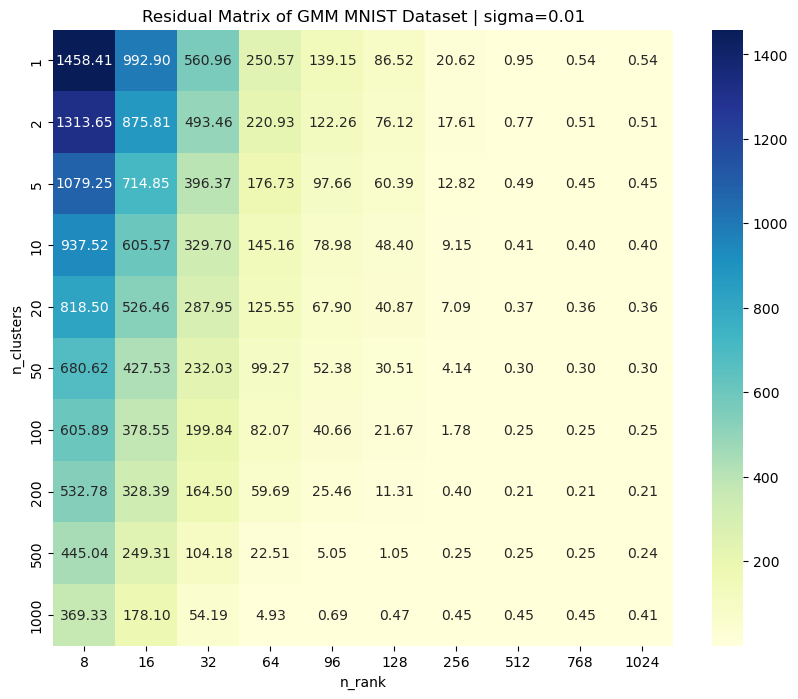

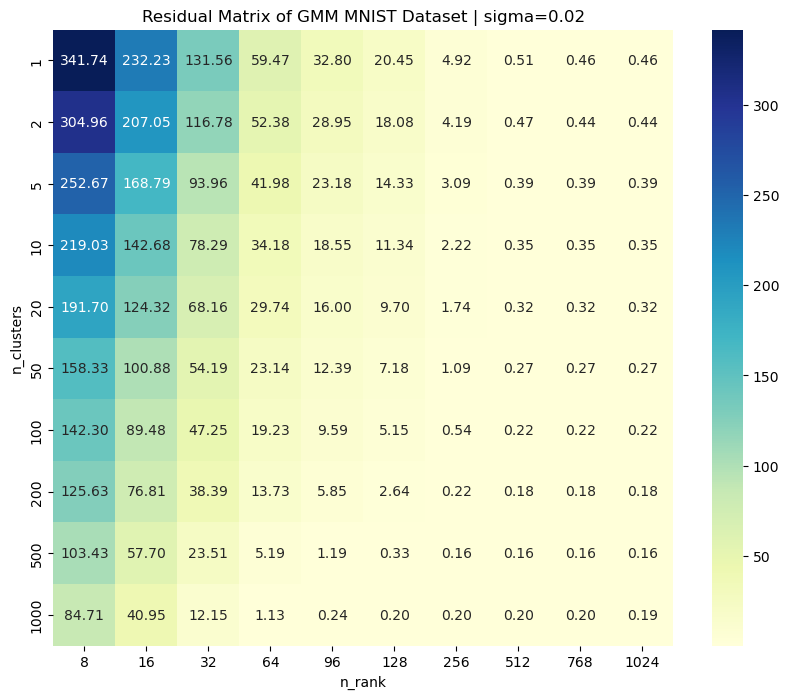

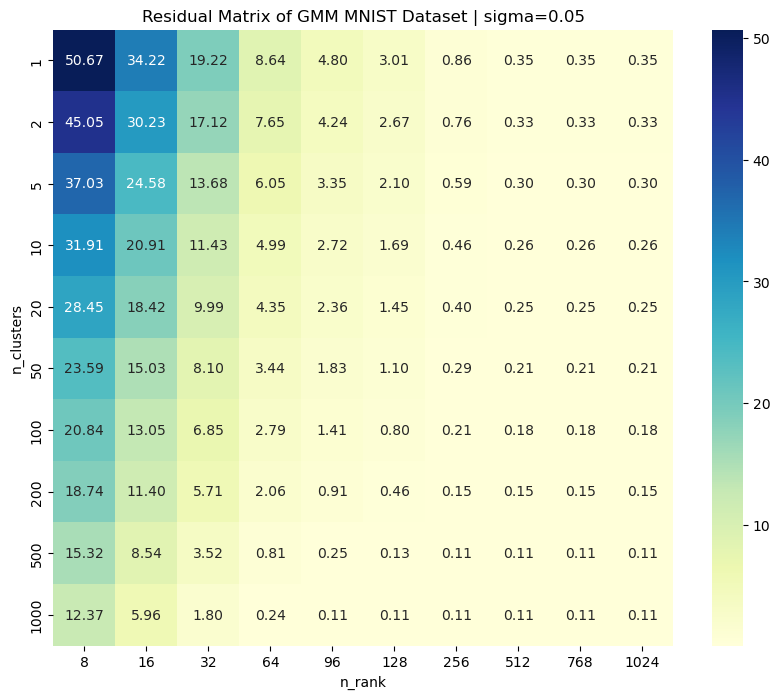

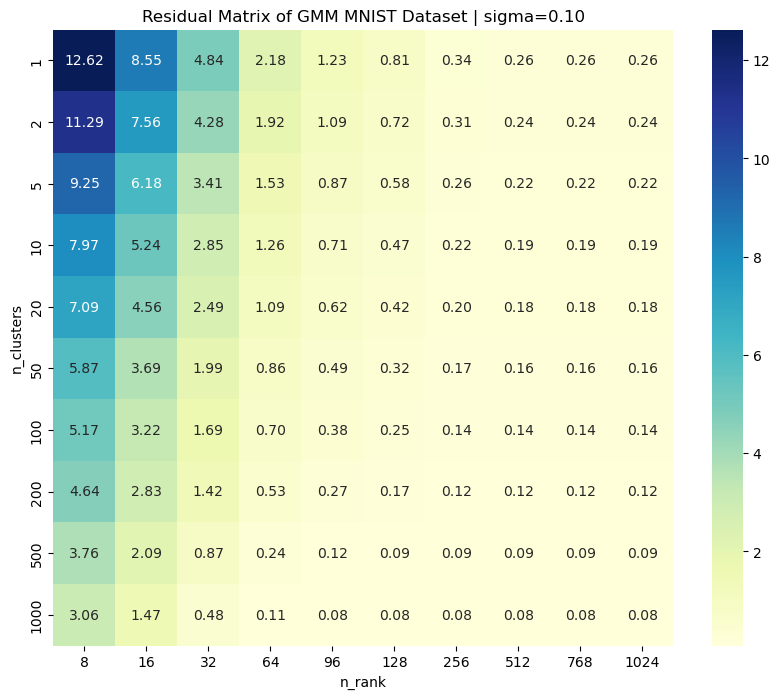

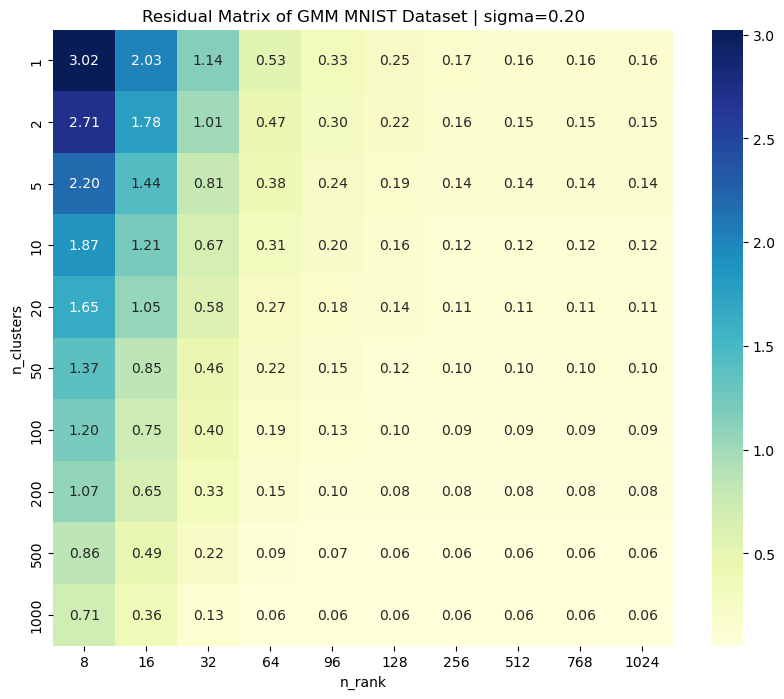

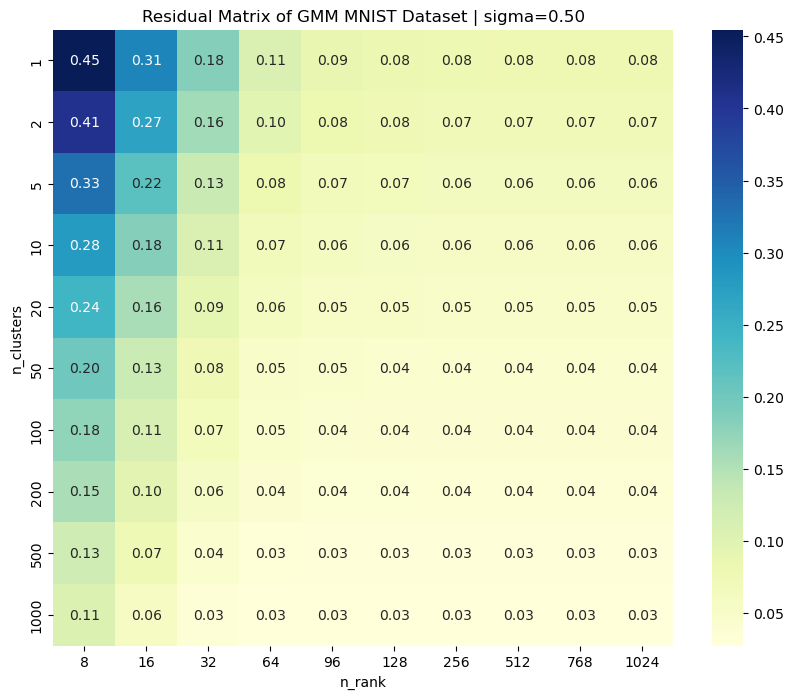

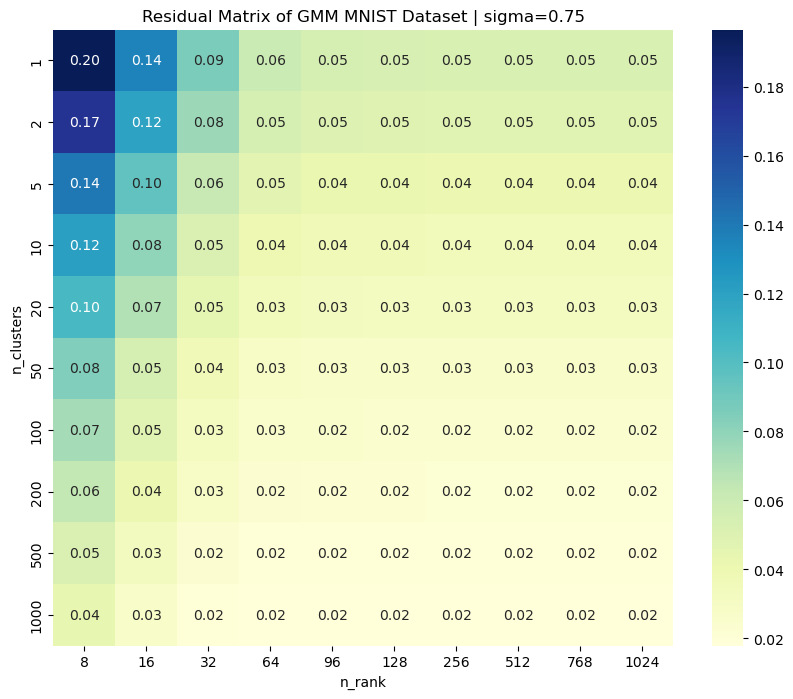

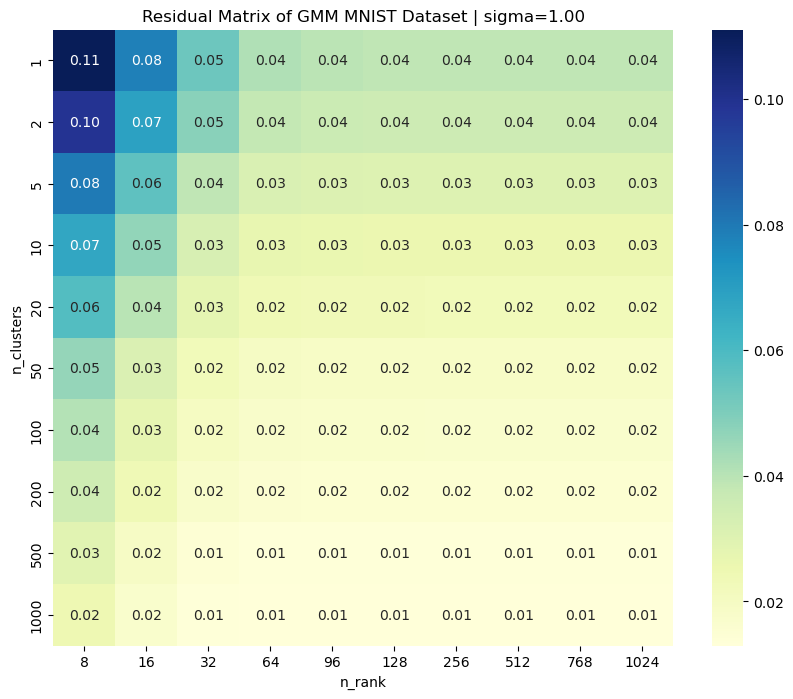

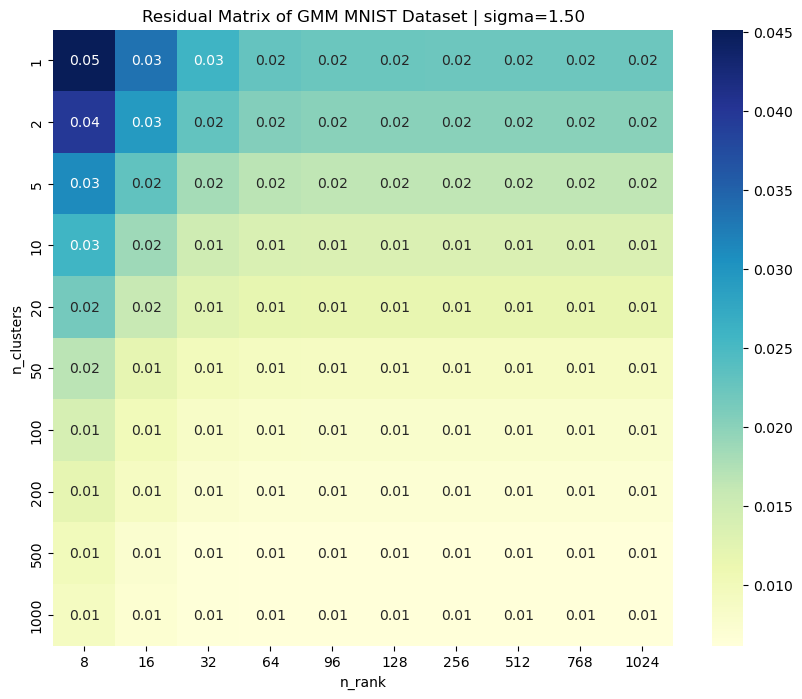

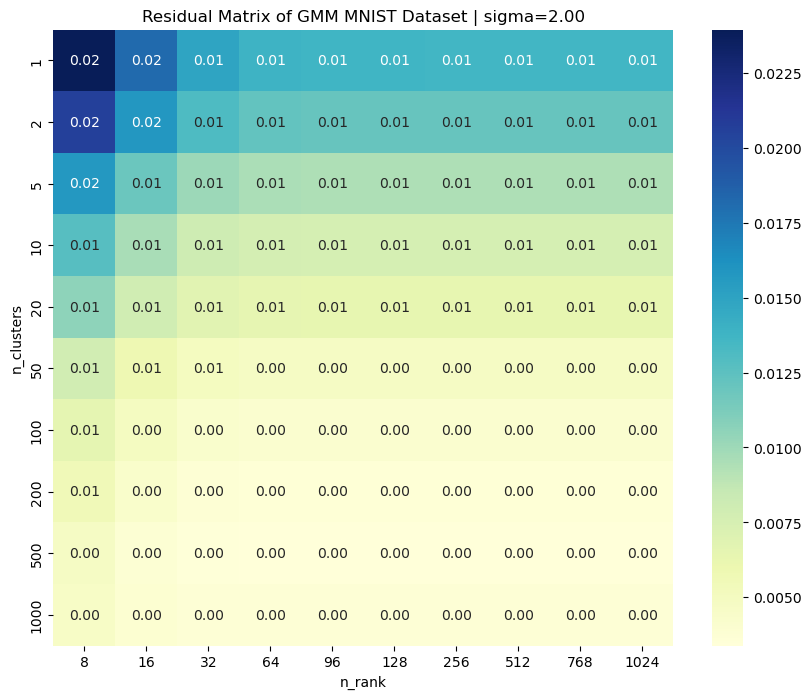

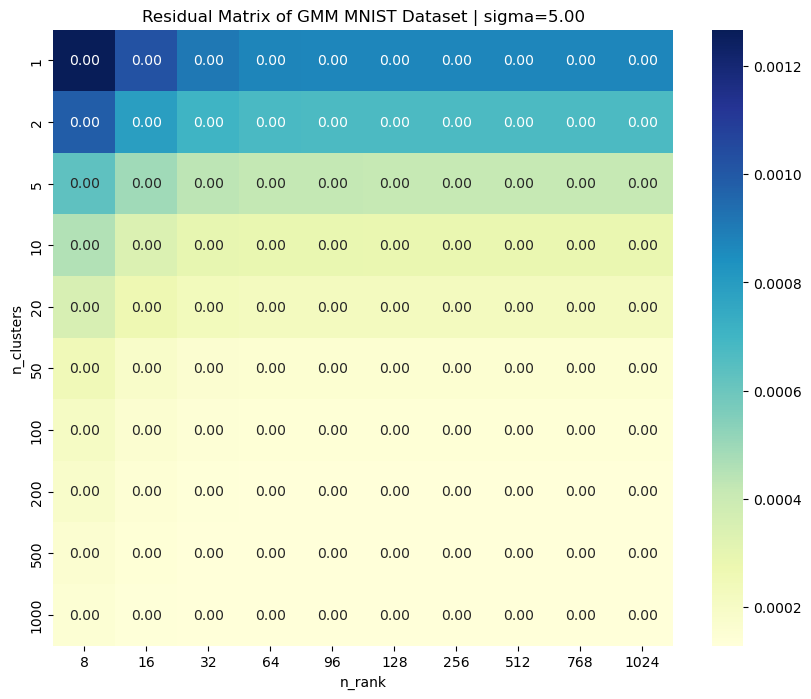

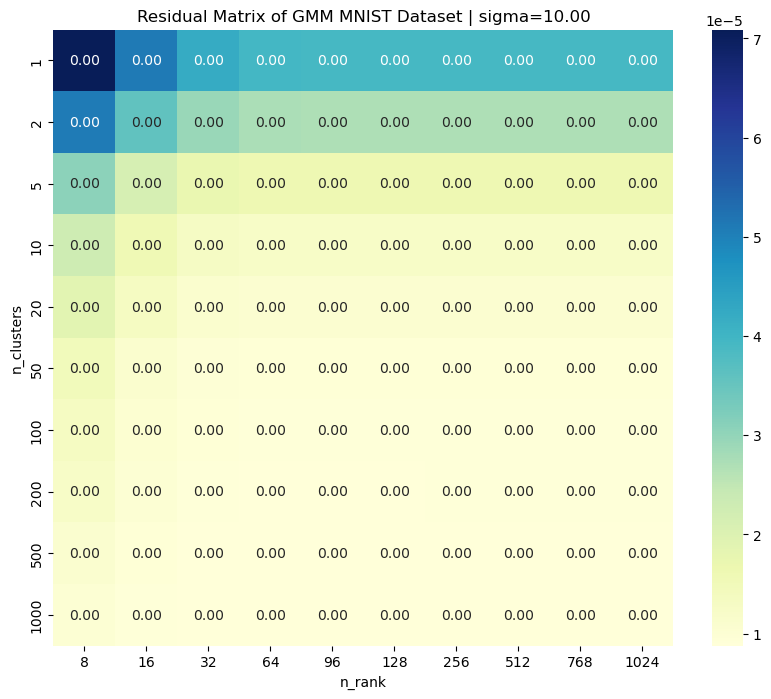

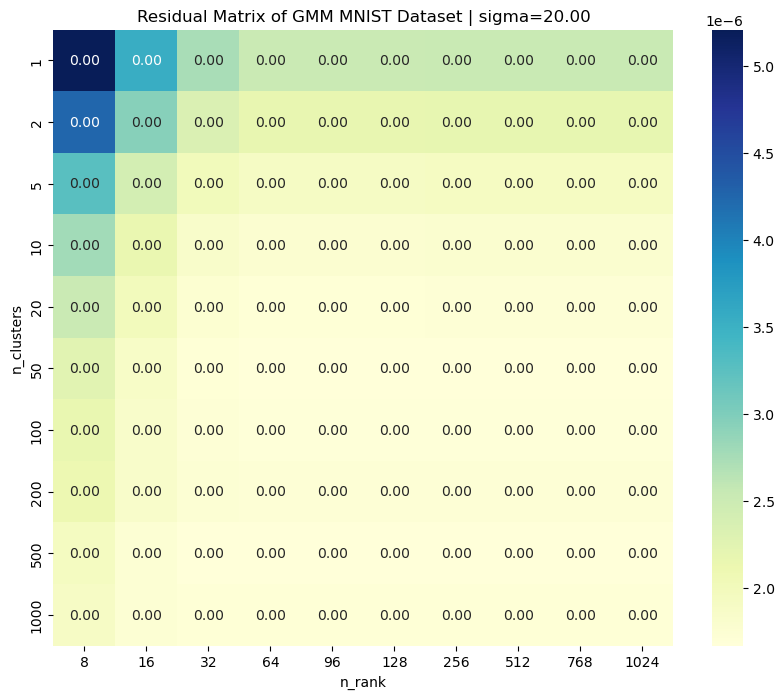

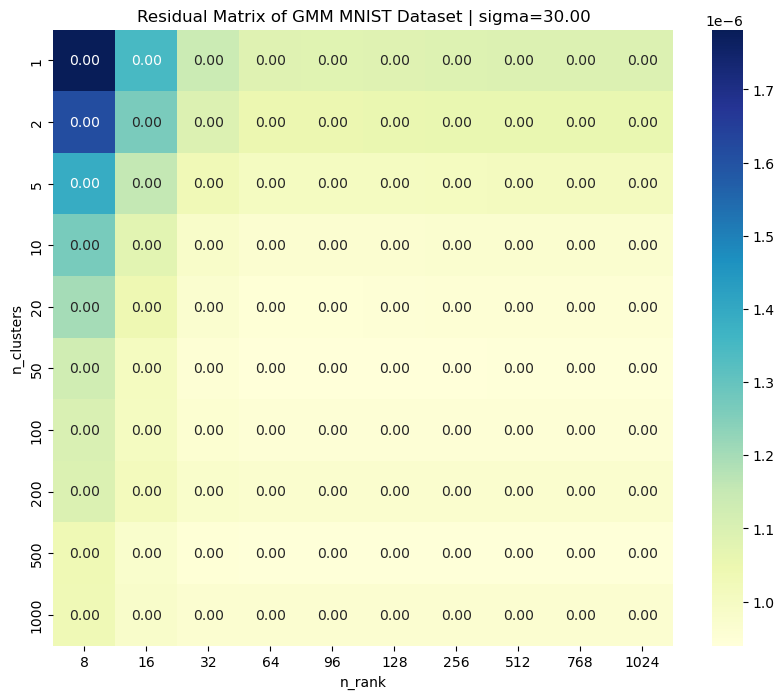

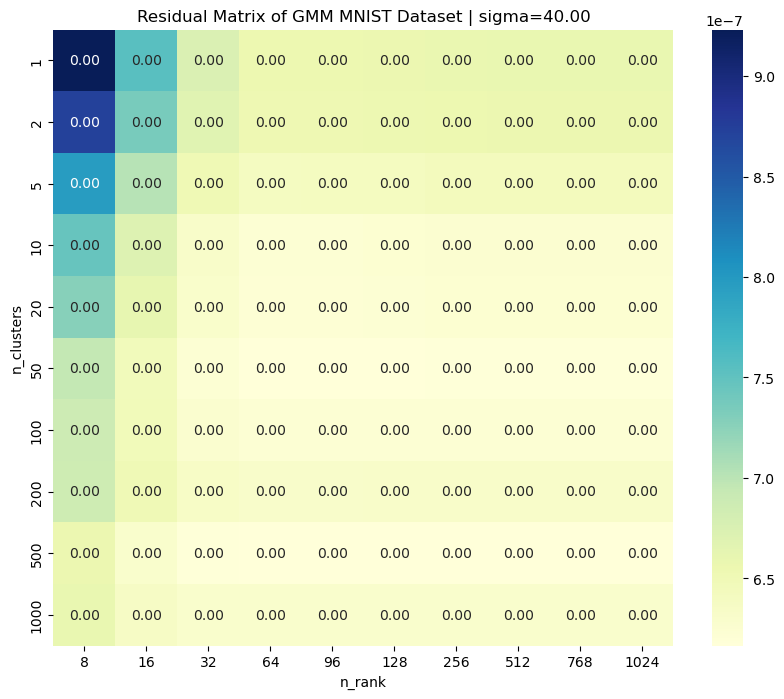

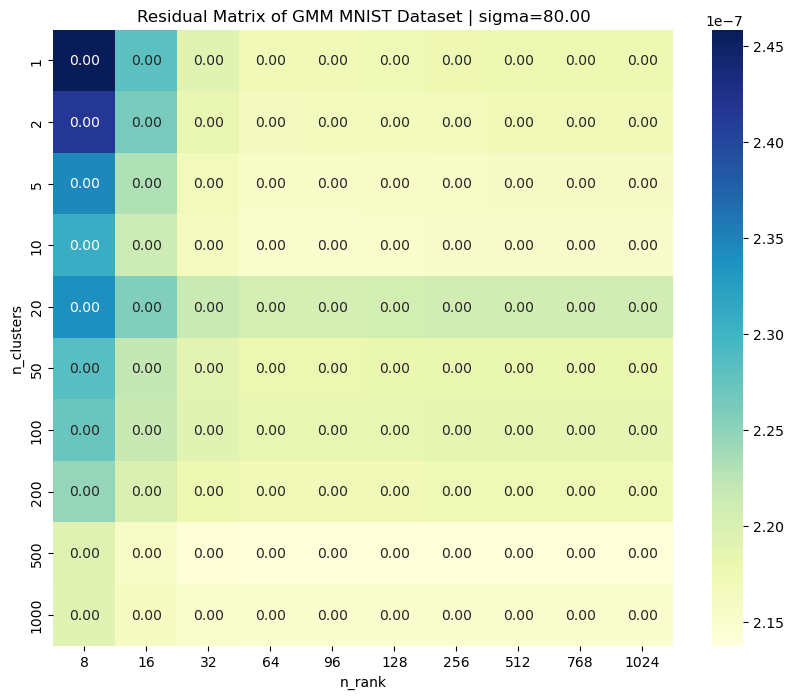

In [40]:
for sigma in df_gmm_rk.sigma.unique():
    # Create a heatmap
    res_mat = []
    for n_clusters in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]:
        for n_rank in [8, 16, 32, 64, 96, 128, 256, 512, 768, 1024]:
            res = 1 - df_gmm_rk[(df_gmm_rk["name"] == f"gmm_{n_clusters}_mode_{n_rank}_rank") & 
                                (df_gmm_rk.sigma == sigma)]["St_EV"].values
            res_mat.append({"n_clusters": n_clusters, "n_rank": n_rank, "residual": res[0]})
    res_mat = pd.DataFrame(res_mat)
    plt.figure(figsize=(10, 8))
    sns.heatmap(res_mat.pivot_table(index="n_clusters", columns="n_rank", 
                        values="residual", aggfunc="mean"), 
                annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Residual Matrix of GMM MNIST Dataset | sigma=%.2f" % sigma)
    plt.ylabel("Number of Modes")
    plt.xlabel("Rank")
    plt.show()